In [14]:
import numpy as np
import pandas as pd
import os

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric

import urllib.request
import tarfile

# Node classification 
 
 __GNN must predict the correct label for the node. Dataset has nodes and their features__
 
 __cora has papers and citations__
 
For each node, there is an input feature vector  and label 

# Classification problem 
## classifying documents in a citation graph  where labels are only available for a small subset of nodes..

In [34]:

coraTarFile = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'
tarfiles = urllib.request.urlopen(coraTarFile)


In [17]:
zip_file = tarfile.open(fileobj=tarfiles, mode="r|gz")
for tarinfo in zip_file:
    print(tarinfo.name, "is", tarinfo.size, "bytes in size and is ", end="")
    if tarinfo.isreg():
        print("a regular file.")
        
    elif tarinfo.isdir():
        print("a directory.")
    else:
        print("something else.")
zip_file.close()
data_dir = os.path.join('.', "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)
print(papers.subject.value_counts())

cora is 0 bytes in size and is a directory.
cora/README is 1560 bytes in size and is a regular file.
cora/cora.cites is 69928 bytes in size and is a regular file.
cora/cora.content is 7823427 bytes in size and is a regular file.
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


# Opening the tarfile to view the contents

## normalizes the tensor image with mean and standard deviation.

In [42]:

dataset = Planetoid(coraTarFile, 'cora', transform=T.NormalizeFeatures())
data = dataset[0]

In [47]:
len(data.test_mask)

2708

## Cora Data objects holds a label for each node, and additional node-level attributes: train_mask, val_mask and test_mask, where

### train_mask denotes against which nodes to train (140 nodes),

### val_mask denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes),

### test_mask denotes against which nodes to test (1000 nodes).

# Planetoid
__The data object you retrieve from the Planetoid dataset is a single graph with following attributes:__


__x the node features, hence it's dimension is number of nodes (2703) times feature dimension (1433)__

__edge_index the edge list__

__y the "ground truth"/class labels or in that specific case the classification of the papers. Hence, it's shape is the number of nodes.__

__The three masks: train_mask, val_mask, test_mask. If I access them via data.train_mask, it gives me a boolean tensor with the length = number of nodes. This is the "default split" of the dataset. They should be disjoint and if True the respective node is in that set.__

In [19]:
# Unique labels or classification of papers
print("# of unique papers ", np.unique(data.y))

# of unique papers  [0 1 2 3 4 5 6]


In [55]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of classes:\t\t",np.unique(data.y))
print("number of node features:\t",data.num_node_features)
print("number of edge features:\t",data.num_edge_features)
print("X shape: ", data.x.shape)
print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)


cora()
number of graphs:		 1
number of classes:		 7
number of classes:		 [0 1 2 3 4 5 6]
number of node features:	 1433
number of edge features:	 0
X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])


# Unique classes
['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [44]:
# Unique labels or classification of papers
print("# of unique papers ", np.unique(data.y))

# check training nodes
print("# of nodes to train on: ", data.train_mask.sum().item())

# check test nodes
print("# of nodes to test on: ", data.test_mask.sum().item())

# check validation nodes
print("# of nodes to validate on: ", data.val_mask.sum().item())

# of unique papers  [0 1 2 3 4 5 6]
# of nodes to train on:  140
# of nodes to test on:  1000
# of nodes to validate on:  500


In [21]:
print(data)
print(data.y[0])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor(3)


In [22]:
print("X shape: ", data.x.shape)
print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)
print(data.num_node_features)


X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])
1433


# set the device dynamically in your code, you can use



In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# we train a two-layer GCN 

## Train all models for a maximum of 200 epochs  
## The GCN model uses Adam optimizer with a learning rate of 0.01

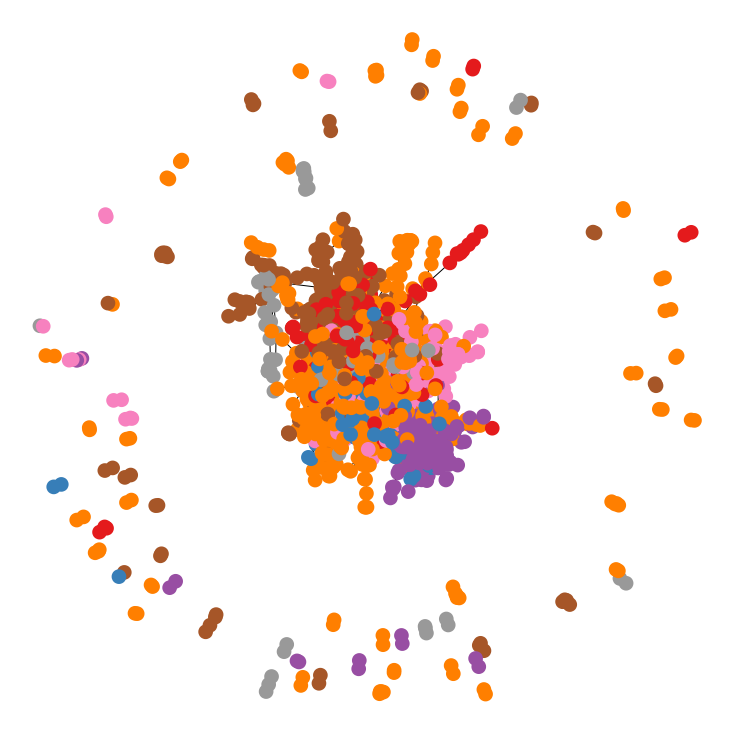

In [26]:
#from torch_geometric.data import Data
import torch_geometric
from torch_geometric.utils.convert import to_networkx
import networkx as nx
plt.figure(figsize=(10, 10))
cora = torch_geometric.data.Data(x=data.x[:500], edge_index=data.edge_index[:500])
#cora=data
g = torch_geometric.utils.to_networkx(cora, to_undirected=True)
coragraph = to_networkx(cora)
node_labels = data.y[list(coragraph.nodes)].numpy()
#nx.draw(g)

nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6)

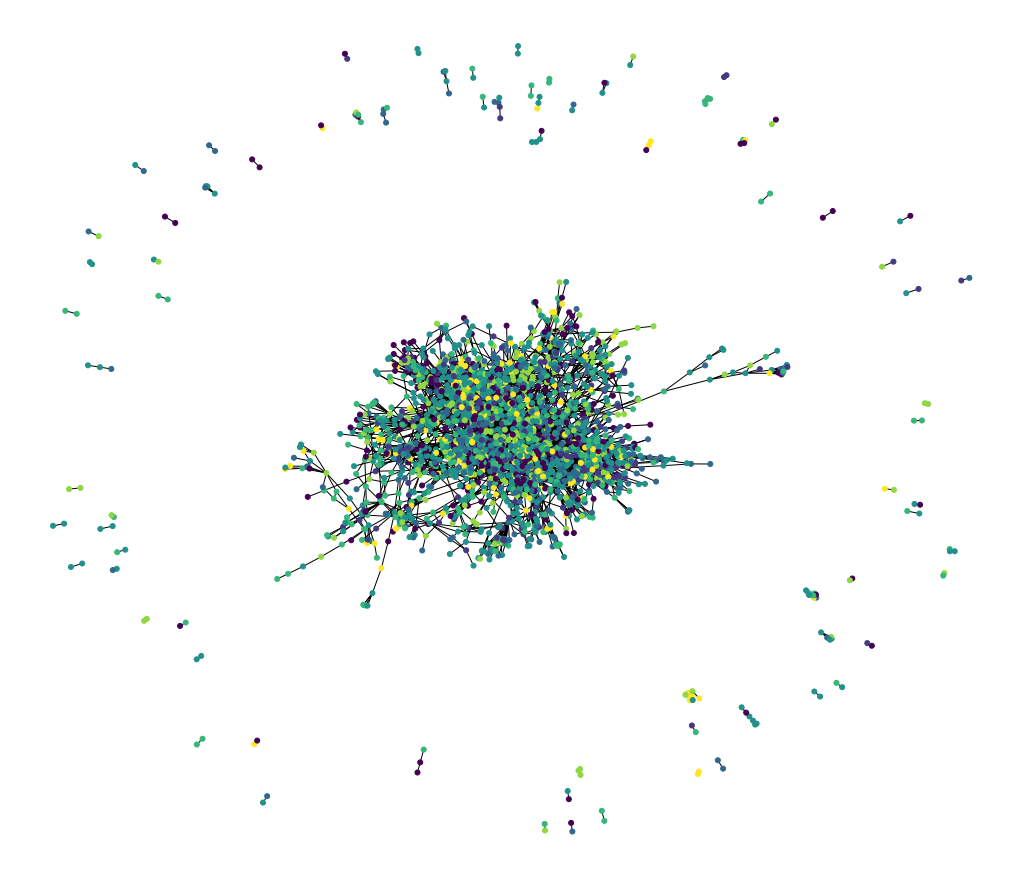

In [27]:
coragraph = to_networkx(data)

node_labels = data.y[list(coragraph.nodes)].numpy()

import matplotlib.pyplot as plt
plt.figure(1,figsize=(14,12)) 
nx.draw_spring(g, node_size=25, node_color=node_labels)

In [28]:
# useful function for computing accuracy
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

In [ ]:
# The model below uses two GCNConv layers. 
#The first layer is followed by a non-linearity ReLU and Dropout. 
#The result is fed to the second layer on top of which 
#we apply Softmax to get distribution over the number of classes.

In [36]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        # x: Node feature matrix 
        # edge_index: Graph connectivity matrix 

        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [37]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [38]:
print("Graph Convolutional Network (GCN):")
GCN()

Graph Convolutional Network (GCN):


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [39]:
# train the model
model.train()
losses = []
accuracies = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    correct = compute_accuracy(out.argmax(dim=1)[data.train_mask], data.y[data.train_mask])
    acc = int(correct) / int(data.train_mask.sum())
    losses.append(loss.item())
    accuracies.append(acc)

    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))


Epoch: 10, Loss: 1.8736, Training Acc: 0.7429
Epoch: 20, Loss: 1.7610, Training Acc: 0.7571
Epoch: 30, Loss: 1.5648, Training Acc: 0.8357
Epoch: 40, Loss: 1.3959, Training Acc: 0.8429
Epoch: 50, Loss: 1.1443, Training Acc: 0.8714
Epoch: 60, Loss: 0.9732, Training Acc: 0.9214
Epoch: 70, Loss: 0.8064, Training Acc: 0.9357
Epoch: 80, Loss: 0.6845, Training Acc: 0.9357
Epoch: 90, Loss: 0.6223, Training Acc: 0.9214
Epoch: 100, Loss: 0.5695, Training Acc: 0.9214
Epoch: 110, Loss: 0.5148, Training Acc: 0.9786
Epoch: 120, Loss: 0.4468, Training Acc: 0.9500
Epoch: 130, Loss: 0.4040, Training Acc: 0.9786
Epoch: 140, Loss: 0.3685, Training Acc: 0.9786
Epoch: 150, Loss: 0.3636, Training Acc: 0.9643
Epoch: 160, Loss: 0.3909, Training Acc: 0.9857
Epoch: 170, Loss: 0.3725, Training Acc: 0.9786
Epoch: 180, Loss: 0.3320, Training Acc: 0.9714
Epoch: 190, Loss: 0.3335, Training Acc: 0.9571
Epoch: 200, Loss: 0.2912, Training Acc: 0.9929


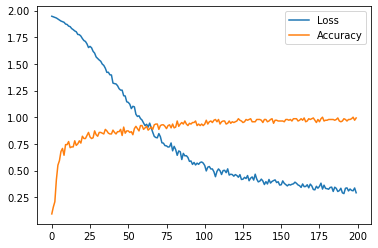

In [56]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(accuracies)
plt.legend(['Loss', 'Accuracy'])
plt.show()

In [40]:
# evaluate the model on test set
model.eval()
pred = model(data).argmax(dim=1)
correct = compute_accuracy(pred[data.test_mask], data.y[data.test_mask])
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8140
